# Train the model

In [1]:
import os

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2

In [2]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.activations as activations
import tensorflow.keras.metrics as metrics

In [399]:
shape = (224, 224)
train_dir = os.path.join('Rails', 'Train')
train_mask_dir = os.path.join('Rails', 'Train-Mask')
train_xml_path = os.path.join(train_dir, 'annotations.xml')

## Preprocessing

Preprocessing labels from xml to masks

In [209]:
def save_masks(ds_dir, save_dir, xml_path):
    """Saves masks using polylines of the dataset
    
    Args:
        ds_dir (str): dataset dir path
        save_dir (str): dir path where to store masks
        """
    os.makedirs(save_dir, exist_ok=True)
    # xml_path = os.path.join(ds_dir, 'annotations.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for image_element in root.iter('image'):
        polylines = image_element.findall('polyline')
        if not polylines:
            continue
        width, height = int(image_element.get('width')), int(image_element.get('height'))
        name = image_element.get('name')
        output = np.zeros((height, width, 3))
        for polyline in polylines:
            # label, points = polyline.get('label'), polyline.get('points')
            points =  polyline.get('points')
            points =  [coords.split(',') for coords in points.split(';')]
            points = np.array(points , dtype = np.float32).astype(np.int32)
            # cv2.polylines(output, [points], False, (255, 0, 0), 30)
            cv2.polylines(output, [points], False, (255, 0, 0), 10)
        output = np.uint8(output)
        output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
        output = np.where(output>0, 255, 0)
        save_path = os.path.join(save_dir, name)
        if not cv2.imwrite(save_path, output):
            raise OSError(f"{name} couldn't be saved")

save_masks(os.path.join(train_mask_dir, 'img'), os.path.join(train_mask_dir, 'img'), train_xml_path)

In [211]:
def get_ds(images_dir, masks_dir, shape = (800, 800)):
    """Reads images and masks, then returns dataset
    
    Args:
        images_dir: images dir path
        masks_dir: masks dir path
        shape: shape to resize

    Returns:
        tuple: pair of arrays corresponding images and masks respectively
    """
    # ds = []
    mask_pattern = os.path.join(masks_dir, '*.jpg')
    images, masks = [], []
    masks_paths = glob.glob(mask_pattern)
    for mask_path in masks_paths:
        # print(mask_path)
        img_name = os.path.basename(mask_path)
        img_path = os.path.join(images_dir, img_name)
        img, mask = cv2.imread(img_path), cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None or mask is None:
            raise OSError(f'Problems with image: image name is {img_name}')
        # ds.append((img, mask))
        images.append(img)
        masks.append(mask)
    images = np.array(images, dtype=np.float32)
    masks  = np.array(masks, dtype=np.float32)
    # masks  = np.where(masks>0, 1.,0)
    masks  = masks[..., np.newaxis]
    images/=255.
    masks/=255.
    return np.array(images), np.array(masks)

In [212]:
# images, masks = get_ds(train_dir, train_mask_dir, shape)
# images, masks = os.path.join(train_dir, 'img'), os.path.join(train_mask_dir, 'img'), shape)

In [213]:
img_paths = set(map(os.path.basename, glob.glob(os.path.join(train_dir, 'img', '*.jpg'))))
mask_paths = set(map(os.path.basename, glob.glob(os.path.join(train_mask_dir, 'img', '*.jpg'))))

for img_name in img_paths.difference(mask_paths):
    os.remove(os.path.join(train_dir, 'img', img_name))

In [400]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 999
batch_size = 4
image_datagen = ImageDataGenerator(
                rescale = 1/255.,
                rotation_range = 20,
                )
mask_datagen = ImageDataGenerator(
                rescale = 1/255.,
                rotation_range = 20,
                )

image_generator =image_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    target_size = shape,
                                                    class_mode=None, seed=seed)

mask_generator = mask_datagen.flow_from_directory(train_mask_dir,
                                                    batch_size = batch_size,
                                                    target_size = shape,
                                                    color_mode = 'grayscale',
                                                    class_mode=None, seed=seed)

train_ds = zip(image_generator, mask_generator)

Found 702 images belonging to 1 classes.
Found 702 images belonging to 1 classes.


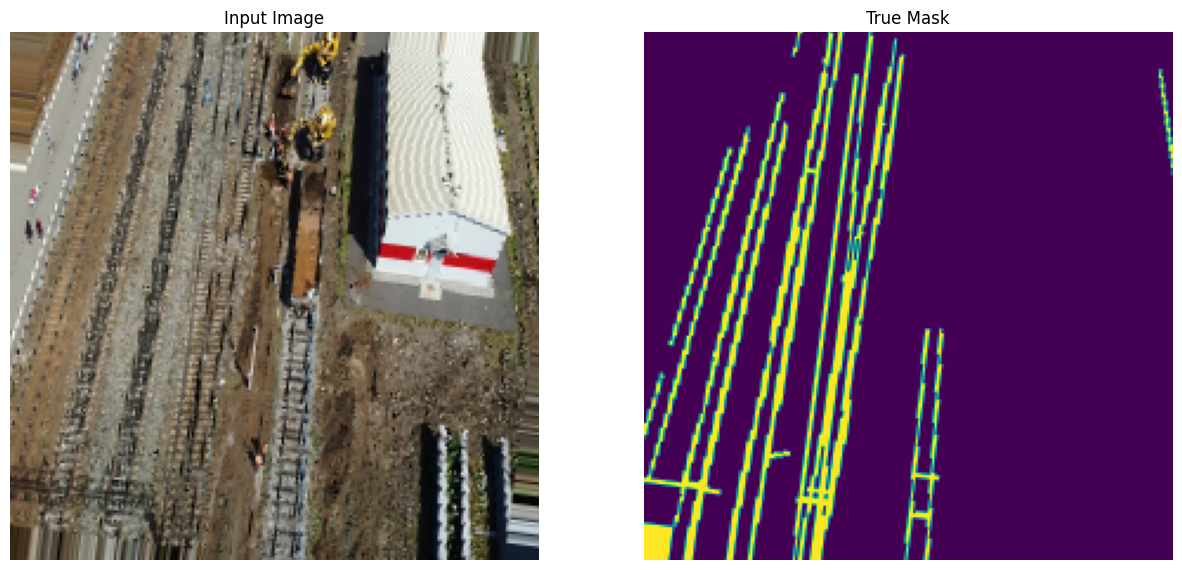

In [401]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# for sample_images, sample_masks in train_ds.take(2):
for sample_images, sample_masks in train_ds:
  sample_image, sample_mask = sample_images[0], sample_masks[0]
  display([sample_image, sample_mask])
  break

## Training

U-Net with MobileNetv2

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [420]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(shape[0], shape[1], 3), include_top=False)
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# down_stack.trainable = True 
down_stack.trainable = False 
# for layer in down_stack.layers[:-7]:
#     layer.trainable = False

In [421]:
down_stack.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_30[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [422]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [423]:
def unet_model(output_channels, shape):
  inputs = tf.keras.layers.Input(shape=shape)

  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same', activation = 'sigmoid')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [424]:
def dice(y_true, y_pred):
    return (2. * tf.keras.backend.sum(y_true * y_pred) + 1.) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1.)

In [425]:
# model = tf.keras.models.load_model('model.hdf5', compile = True, custom_objects={'dice': dice})
model = unet_model(1, (*shape, 3))
model.compile(
            #   optimizer=tf.keras.optimizers.Adam(1e-1),
              optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=[dice])

In [426]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_28 (Functional)          [(None, 112, 112, 9  1841984     ['input_31[0][0]']               
                                6),                                                               
                                 (None, 56, 56, 144                                               
                                ),                                                                
                                 (None, 28, 28, 192                                        

In [427]:
# model_name = test_model.name
model_name = 'new_model'
best_w = tf.keras.callbacks.ModelCheckpoint(
    f'{model_name}_best.hdf5',
    monitor='dice',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
    )

last_w = tf.keras.callbacks.ModelCheckpoint(
    f'{model_name}_last.hdf5',
    monitor='dice',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto'
    )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='dice', patience=5, mode = 'max')

callbacks = [best_w, last_w, early_stopping]

In [ ]:
EPOCHS = 5
model_history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=175, callbacks=callbacks, verbose = 1)

## Example

In [412]:
test_dir = os.path.join('Rails', 'Test')
test_mask_dir = os.path.join('Rails', 'Test-Mask')
test_xml_path = os.path.join('Rails', 'Test', 'test_annotations.xml')
save_masks(os.path.join(test_mask_dir, 'img'), os.path.join(test_mask_dir, 'img'), test_xml_path)

In [413]:
test_images, test_masks = get_ds(os.path.join(test_dir, 'img'), os.path.join(test_mask_dir, 'img'), shape)

In [414]:
test_images.shape, test_masks.shape

((20, 224, 224, 3), (20, 224, 224, 1))

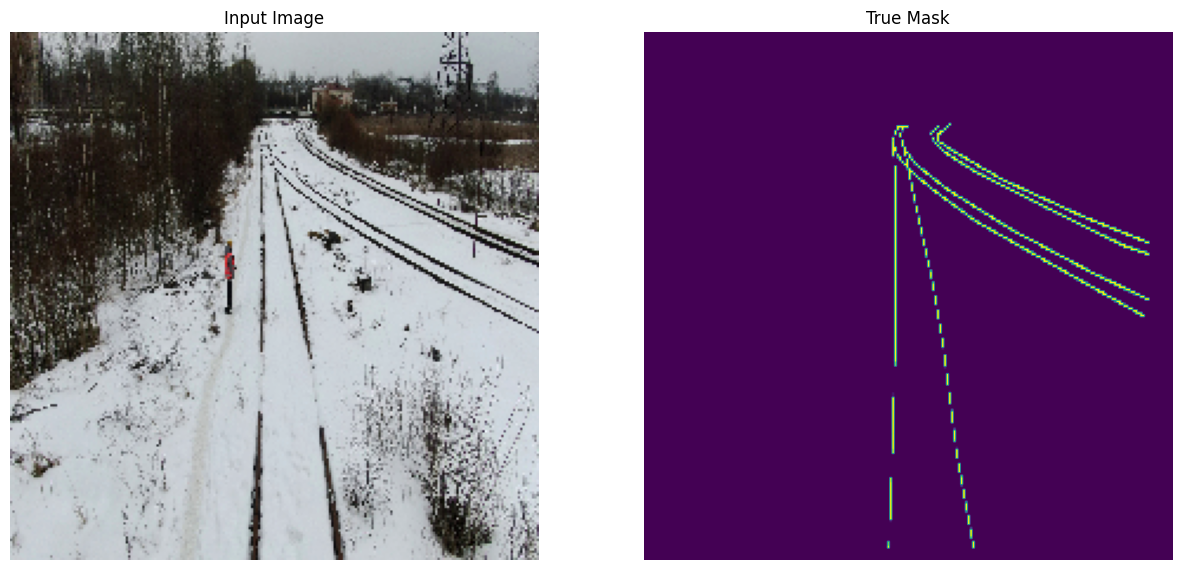

In [449]:
i = 2
display([test_images[i], test_masks[i]])

1/1 [==============================] - 1s 900ms/step


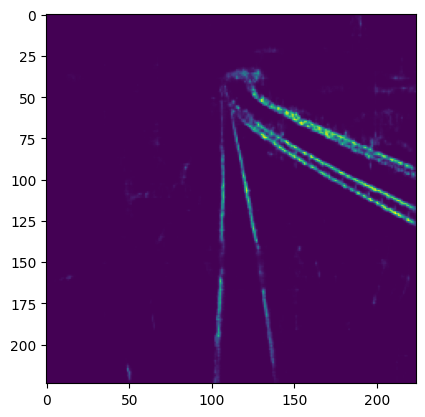

In [450]:
model = tf.keras.models.load_model('new_model_last.hdf5', compile = True, custom_objects={'dice': dice})
preds = model.predict(test_images[i][np.newaxis,...])
plt.imshow(preds[0])
plt.show()

## Convert predictions into lines CVAT data

Export scripts for CVAT

In [111]:
from skimage.morphology import skeletonize

rho = 1
theta = np.pi / 180
threshold = 50
min_line_length = 50
max_line_gap = 50

def get_lines(preds):
    """Extracts lines from predictions mask"""

    skeleton_preds = skeletonize(preds)
    skeleton_preds = np.where(skeleton_preds, 255, 0).astype(np.uint8)
    lines = cv2.HoughLinesP(skeleton_preds, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
    return lines

def save_labels(xml_path, img_paths):
    """Saves labels in xml CVAT format
    Args:
        xml_path: path where xml file will be stored
        img_paths: images that should be used for labels
    """
    counter = 0
    label_type = 'polyline'
    anno = ET.Element('annotations')
    meta = ET.SubElement(anno, 'meta')
    task = ET.SubElement(meta, 'task')
    labels = ET.SubElement(task, 'labels')
    assignee = ET.SubElement(task, 'assignee')
    version = ET.SubElement(anno, 'version')
    version.text = '1.1'
    # anno_files = glob.glob(os.path.join(annotations_dir, '*.json'))
    # Add classes info
    label = ET.SubElement(labels, 'label')
    label_name = ET.SubElement(label, 'name')
    label_name.text = 'Rail'
    # Preprocess annotations
    for img_path in img_paths:
        img = cv2.imread(img_path)
        image_element = ET.SubElement(anno, 'image')
        image_element.set('id', str(counter))
        image_element.set('name', os.path.basename(img_path))
        image_element.set('height', str(img.shape[0]))
        image_element.set('width', str(img.shape[1]))
        # Get predictions
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(img, shape)/255.
        x = x[np.newaxis, ...]
        preds = model(x)
        preds = np.where(preds[0].numpy()>0.5, 255, 0).astype(np.uint8)
        preds = cv2.resize(preds, img.shape[1::-1])
        lines = get_lines(preds)
        if lines is not None:
            for line in lines:
                label = ET.SubElement(image_element, label_type)
                label.set('label', 'Rail')
                label.set('occluded', '0')
                label.set('source', 'manual')
                x1, y1, x2, y2 = line.flatten()
                points = f'{x1}, {y1}; {x2}, {y2}'
                label.set('points', points)
                label.set('z_order', '0')
        else:
            print(f'{img_path} does not have lines')
    b_xml = ET.tostring(anno)
    with open(xml_path, "wb") as f:
        f.write(b_xml)

In [ ]:
save_labels('new_annos.xml', glob.glob(os.path.join(train_dir, 'img', '*.jpg')))